In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import time
import numpy as np
import pandas as pd
from torch.utils.data.dataset import Dataset
from tqdm import tqdm
from torchvision import transforms
import torch.nn as nn
from torchvision import models
import torch
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import precision_score, recall_score, f1_score
from torch import nn
from torch.utils.data.dataloader import DataLoader
from matplotlib import pyplot as plt
from numpy import printoptions
import requests
import tarfile
import random
import json
from shutil import copyfile
import pathlib

from typing import List, Dict
from multiprocessing import Pool
from skimage.io import imread
from PIL import Image

import time
import datetime

from tools import get_transform, get_instance_segmentation_model, ObjectDetectionDataSet
from tools import map_class_to_int, save_json, read_json, get_filenames_of_path, adapt_data
from tools import checkpoint_save, show_sample, MutilabelClassificationDataset, evaluate
from tools import MLCDataset, MLCDataLoader
from backbones import GetModel, GetModelNM, BuildModel
from torchmets import sklearn_metrics, compute_full_metrics, compute_tracking_metrics
import shutil
import sys

import re
from math import isnan
from os.path import isfile, join
from neptune.types import File
from torchsummary import summary
from tools import TorchXRayVisionNorm
import itertools as itl

c:\Users\mario\anaconda3\envs\AppleDis\lib\site-packages\neptune\common\warnings.py:62: NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
  warnings.warn(


In [3]:
params = {'OWNER': 'rubsini', 
          'PROJECT': 'ApplePlantDiseases',
          'PARTITION':'../Data/Splits/split1.json',
          'IMGS_PATH':'../Data/224/', 
          'SAVE_PATH': 'Checkpoints/', 
          'SAVE_DIR':'Result_Tables_Archs', 
          'SAVE_FREQ': 50, 
          'EXP_TYPE':['Initial Test Exp' ,'General Board'],
          'LOG_MODEL': True,  
          'BACKBONE': 'resnet101', 
          'MODEL_FREEZE': True, 
          'I_WEIGHTS': False,
          'BATCH_SIZE': 32, 
          'LR': 1e-3, 
          'EPOCHS': 50, 
          'N_WORKERS': 1,
          'SAVE_FREQ': 50,
          'WEIGHT_DECAY': 5e-5,
          'RESIZE': 224,
          'CROP_SIZE': 512,
          'ROTATION_RANGE': 15,
          'TRANSLATION': 0.10,
          'SCALE': (0.85,1.15),
          "IMG_MEAN":[0.485, 0.456, 0.406],
          "IMG_STD":[0.229, 0.224, 0.225]
          }

In [4]:
device = torch.device('cuda')

In [5]:
train_transform = transforms.Compose([
                                      # transforms.RandomCrop(params['CROP_SIZE']),
                                      # transforms.RandomAffine(params['ROTATION_RANGE'], translate=(params['TRANSLATION'], params['TRANSLATION']), scale=params['SCALE']),
                                      # transforms.Resize((params['CROP_SIZE'],params['CROP_SIZE'],)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(params["IMG_MEAN"], params["IMG_STD"])
                                      ])
val_transform = transforms.Compose([
                                    # transforms.Resize((params['CROP_SIZE'],params['CROP_SIZE'],)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(params["IMG_MEAN"], params["IMG_STD"])
                                    ])

In [6]:
train_dataset = MLCDataset(params['PARTITION'], params['IMGS_PATH'], 'Train', train_transform)
val_dataset = MLCDataset(params['PARTITION'], params['IMGS_PATH'], 'Val', train_transform)
test_dataset = MLCDataset(params['PARTITION'], params['IMGS_PATH'], 'Test' , train_transform)

lt = len(train_dataset)+len(val_dataset)+len(test_dataset)
ltr,ptr,lvd,pvd,lts,pts = len(train_dataset), len(train_dataset)/lt, len(val_dataset), len(val_dataset)/lt, len(test_dataset), len(test_dataset)/lt
print('Total data: {} ({:.2f}%)\nTrain data: {} ({:.2f}%)\nVal Data:   {}  ({:.2f}%)\nTest Data:  {}  ({:.2f}%)'.format(lt,lt/lt,ltr,ptr,lvd,pvd,lts,pts))

Total data: 18632 (1.00%)
Train data: 13044 (0.70%)
Val Data:   2774  (0.15%)
Test Data:  2814  (0.15%)


In [7]:
import matplotlib.pyplot as plt

In [8]:
train_dataset[1][0].shape

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


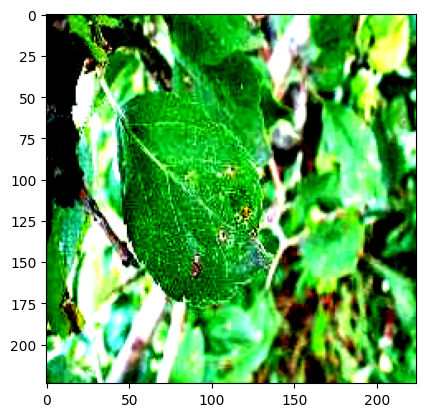

In [9]:
plt.imshow(torch.moveaxis(train_dataset[1][0], 0, -1))

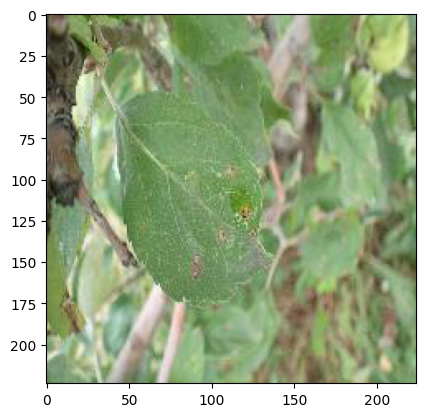

In [10]:
from skimage.io import imread
plt.imshow(imread(params['IMGS_PATH'] + train_dataset.img_names[1]))

In [11]:
train_dataloader = DataLoader(train_dataset, batch_size=params['BATCH_SIZE'], num_workers=params["N_WORKERS"])# , shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=params['BATCH_SIZE'], num_workers=params["N_WORKERS"])
test_dataloader = DataLoader(test_dataset, batch_size=params['BATCH_SIZE'], num_workers=params["N_WORKERS"])

# train_dataloader = MLCDataLoader(train_dataset, params['BATCH_SIZE'])
# val_dataloader = MLCDataLoader(val_dataset, params['BATCH_SIZE'])
# test_dataloader = MLCDataLoader(test_dataset, params['BATCH_SIZE'])

test_freq = int(len(train_dataset)/params['BATCH_SIZE'])

num_train_batches = int(np.ceil(len(train_dataset) / params['BATCH_SIZE']))

In [12]:
next(iter(train_dataloader))

[tensor([[[[-0.6281, -0.7308, -0.8507,  ...,  1.2043,  1.2214,  1.2043],
           [-0.5767, -0.6794, -0.8335,  ...,  1.1529,  1.1187,  1.1187],
           [-0.4911, -0.6109, -0.8164,  ...,  0.9988,  0.9646,  0.9646],
           ...,
           [ 0.0227,  0.1254,  0.2111,  ...,  0.7077,  0.8447,  0.9132],
           [ 0.1254,  0.1939,  0.2624,  ...,  0.8104,  0.8961,  0.9817],
           [ 0.2282,  0.2796,  0.3309,  ...,  0.8618,  0.9303,  1.0159]],
 
          [[-0.4776, -0.5826, -0.6877,  ...,  1.0630,  1.0980,  1.0980],
           [-0.4251, -0.5301, -0.6702,  ...,  1.0105,  1.0105,  1.0105],
           [-0.3375, -0.4601, -0.6527,  ...,  0.9230,  0.8880,  0.8880],
           ...,
           [ 0.1527,  0.2577,  0.3102,  ...,  0.6604,  0.8354,  0.9580],
           [ 0.2577,  0.3277,  0.3627,  ...,  0.7129,  0.8529,  0.9755],
           [ 0.3627,  0.4153,  0.4328,  ...,  0.7654,  0.8880,  0.9755]],
 
          [[-0.6193, -0.7238, -0.8284,  ...,  0.7576,  0.7402,  0.7402],
           [-

In [13]:
# Initialize the model
model = GetModelNM(len(train_dataset.classes), params['BACKBONE'], params['MODEL_FREEZE'], params['I_WEIGHTS'])
# Switch model to the training mode and move it to GPU.
model.train()
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=params['LR'], weight_decay=params['WEIGHT_DECAY'])

# If more than one GPU is available we can use both to speed up the training.
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

os.makedirs(params['SAVE_PATH'], exist_ok=True)

# Loss function
criterion = nn.BCEWithLogitsLoss()

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to C:\Users\mario/.cache\torch\hub\checkpoints\resnet101-cd907fc2.pth


In [20]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 5e-05
)

In [14]:
from torchsummary import summary

In [18]:
summary(model,input_size=(3, 224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [34]:
# Logging metadata
import neptune
# from neptune.new.types import File  
NEPTUNE_API_TOKEN = 'Insert KEY Here'
run = neptune.init_run(project=f'{params["OWNER"]}/{params["PROJECT"]}',
                    api_token=NEPTUNE_API_TOKEN,
                    tags = params['EXP_TYPE'])

run['parameters'] = params
# run.stop()

https://app.neptune.ai/rubsini/ApplePlantDiseases/e/APD-20


In [35]:
# Run training
epoch = 0
iteration = 0
best_macro_F1 = 0.0
while True:
    print('Epoch: ', epoch)
    batch_losses = []
    for imgs, targets in train_dataloader:
        imgs, targets = imgs.to(device), targets.to(device)

        optimizer.zero_grad()

        model_result = model(imgs)
        loss = criterion(model_result, targets.type(torch.float))

        batch_loss_value = loss.item()
        loss.backward()
        optimizer.step()

        run["logs/lr"].log(optimizer.param_groups[0]['lr'])
        run["logs/loss_step"].log(loss)

        batch_losses.append(batch_loss_value)
        with torch.no_grad():
            uap = compute_tracking_metrics(targets.cpu().numpy(), torch.sigmoid(model_result).cpu().numpy())
            run["logs/train_uap"].log(uap)
            result = sklearn_metrics(torch.sigmoid(model_result).cpu().numpy(), targets.cpu().numpy())
            # for metric in result:
                #  run["logs/train_"+metric.replace('/','_')].log(result[metric])

        if iteration % test_freq == 0:
            model.eval()
            with torch.no_grad():
                model_result = []
                targets = []
                for imgs, batch_targets in val_dataloader:
                    imgs = imgs.to(device)
                    model_batch_result = torch.sigmoid(model(imgs))
                    model_result.extend(model_batch_result.cpu().numpy())
                    targets.extend(batch_targets.cpu().numpy())

            result = sklearn_metrics(np.array(model_result), np.array(targets))
            # res_macro_F1 = result['macro/f1']
            uap = compute_tracking_metrics(np.array(targets), np.array(model_result))
            run["logs/validation_uap"].log(uap)
            res_macro_F1 =  uap
            #for metric in result:
                # logger.add_scalar('test/' + metric, result[metric], iteration)
            #    run["logs/test_"+metric.replace('/','_')].log(result[metric])
            print("epoch:{:2d} iter:{:3d} TEST: "
                    "micro f1: {:.3f} "
                    "macro f1: {:.3f} "
                    "samples f1: {:.3f} "
                    "uap: {:.3f}".format(epoch, iteration,
                                                result['micro/f1'],
                                                result['macro/f1'],
                                                result['samples/f1'],
                                                uap))

            model.train()
        iteration += 1

    loss_value = np.mean(batch_losses)
    run["logs/loss_epoch"].log(loss_value)
    print("epoch:{:2d} iter:{:3d} train: loss:{:.3f}".format(epoch, iteration, loss_value))
    print("epoch:{:2d} iter:{:3d} TRAIN: "
                "micro f1: {:.3f} "
                "macro f1: {:.3f} "
                "samples f1: {:.3f} "
                "uap: {:.3f}".format(epoch, iteration,
                                            result['micro/f1'],
                                            result['macro/f1'],
                                            result['samples/f1'],
                                            uap))
    if best_macro_F1 < res_macro_F1 or epoch % params['SAVE_FREQ'] == 0:
        if best_macro_F1 <= res_macro_F1:
            best_macro_F1 = res_macro_F1
            s_model, s_epoch = model, epoch
    if epoch % params['SAVE_FREQ'] == 0:
        checkpoint_save(s_model, params['SAVE_PATH'], s_epoch, run)
    epoch += 1
    if params['EPOCHS'] < epoch:
        break

#params["EXP_TYPE"][0] = params["EXP_TYPE"][1]+"/"+params["EXP_TYPE"][0]
os.makedirs(params["SAVE_DIR"]+"/"+params["EXP_TYPE"][0], exist_ok=True)
params["RUN"] = run
params["PAT_NAMES"] = [i.capitalize() for i in list(train_dataset.classes)] # list(mapping.keys())
print('PARAMS --> PAT_NAMES', params['PAT_NAMES'])
res = [i.start() for i in re.finditer('/', run.get_url())]
params['EXP_NAME'] = run.get_url()[max(res)+1:]
best_epoch = max(get_filenames_of_path(pathlib.Path('Checkpoints')))
model.load_state_dict(torch.load(best_epoch))
params['BEST_EPOCH'] = [int(s) for s in best_epoch.name.split('-')[1].split('.') if s.isdigit()][0]
evaluate(model, val_dataloader, test_dataloader, params)

run.stop()
shutil.rmtree("Checkpoints")

Epoch:  0
epoch: 0 iter:  0 TEST: micro f1: 0.309 macro f1: 0.194 samples f1: 0.312 uap: 0.527
epoch: 0 iter:815 TEST: micro f1: 0.511 macro f1: 0.481 samples f1: 0.389 uap: 0.897
epoch: 0 iter:816 train: loss:0.359
epoch: 0 iter:816 TRAIN: micro f1: 0.511 macro f1: 0.481 samples f1: 0.389 uap: 0.897
saved & uploaded checkpoint: Checkpoints/checkpoint-000000.pth
Epoch:  1
epoch: 1 iter:1630 TEST: micro f1: 0.592 macro f1: 0.575 samples f1: 0.485 uap: 0.907
epoch: 1 iter:1632 train: loss:0.301
epoch: 1 iter:1632 TRAIN: micro f1: 0.889 macro f1: 0.500 samples f1: 0.917 uap: 1.000
Epoch:  2
epoch: 2 iter:2445 TEST: micro f1: 0.617 macro f1: 0.607 samples f1: 0.516 uap: 0.913
epoch: 2 iter:2448 train: loss:0.288
epoch: 2 iter:2448 TRAIN: micro f1: 0.889 macro f1: 0.500 samples f1: 0.917 uap: 1.000
Epoch:  3
epoch: 3 iter:3260 TEST: micro f1: 0.623 macro f1: 0.609 samples f1: 0.526 uap: 0.916
epoch: 3 iter:3264 train: loss:0.283
epoch: 3 iter:3264 TRAIN: micro f1: 0.571 macro f1: 0.278 samp

KeyboardInterrupt: 

In [36]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/rubsini/ApplePlantDiseases/e/APD-20/metadata
